# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression

from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

In [2]:
# Ограничим число знаков после запятой для вывода табличных данных.
pd.options.display.float_format = '{:0.3f}'.format

Загрузим и посмотрим данные.

In [3]:
url = 'https://code.s3.yandex.net/datasets/'

In [4]:
try:
    geo_df_0 = pd.read_csv(url +'geo_data_0.csv')
    geo_df_1 = pd.read_csv(url +'geo_data_1.csv')
    geo_df_2 = pd.read_csv(url +'geo_data_2.csv')
except:
    print('Не удалось загрузить файл, проверьте путь.')

In [5]:
# Отобразим первые строки для каждого датафрейма.
geo_dfs = [geo_df_0, geo_df_1, geo_df_2]
[display(df.sample()) for df in geo_dfs];

,id,f0,f1,f2,product
38465,eN9cU,-1.067,-0.038,3.445,84.301


,id,f0,f1,f2,product
40207,ssmlI,9.697,-3.732,2.997,80.860


,id,f0,f1,f2,product
50662,n0K4U,0.365,2.839,3.393,108.687


Проверим наличие пропусков и тип данных.

In [6]:
pd.concat([geo_df_0] + [geo_df_1] + [geo_df_2]).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       300000 non-null  object 
 1   f0       300000 non-null  float64
 2   f1       300000 non-null  float64
 3   f2       300000 non-null  float64
 4   product  300000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 13.7+ MB


Никаких проблем с данными не обнаружено. При этом встречаются одинаковые id.

In [7]:
pd.concat([geo_df_0] + [geo_df_1] + [geo_df_2]).describe(include='all')

,id,f0,f1,f2,product
count,300000,300000.000,300000.000,300000.000,300000.000
unique,299951,NaN,NaN,NaN,NaN
top,uSye4,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,0.548,-1.516,2.497,85.442
std,NaN,5.317,3.900,2.917,46.519
min,NaN,-31.610,-26.359,-12.088,0.000
25%,NaN,-1.003,-2.479,0.648,52.667
50%,NaN,0.348,-0.230,2.491,84.039
75%,NaN,1.755,0.679,4.345,124.174


Посмотрим, как данные коррелируют между собой.

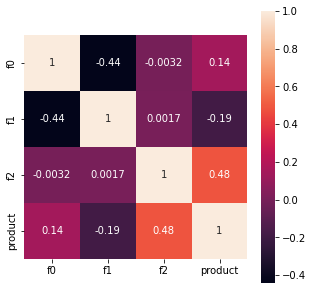

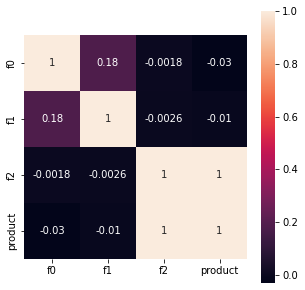

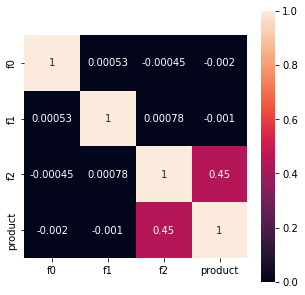

In [8]:
for df in geo_dfs:
    fig = plt.figure(figsize=(5,5))
    ax = sns.heatmap(df.corr(), annot=True, square=True)

Целевая переменная product сильнее всего зависит от признака f2, при этом для 1 региона (geo_df_1) получилась идеальная линейная зависимость.

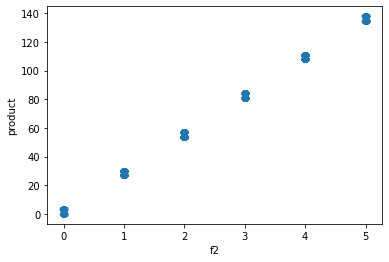

In [9]:
geo_df_1.plot.scatter(x='f2', y='product');

## Обучение и проверка модели

Удалим признак id, так как он не нужен в нашей задаче.

In [10]:
geo_df_0.drop(columns='id', inplace=True)
geo_df_1.drop(columns='id', inplace=True)
geo_df_2.drop(columns='id', inplace=True)

Создадим несколько вспомогательных функций.

In [11]:
# Разбивка данных на features и target, а затем на train и test.
def features_target_get(df):
    features = df.drop(columns=['product'])
    target = df['product']
    # Разобьём данные на тренировочную и тестовую выборки.
    return train_test_split(
        features, target, test_size=0.25, random_state=38
    )

In [12]:
# Вывод RMSE и среднего запаса для разных регионов.
def comparison_and_pred(model, dfs):
    dict_ = {}
    
    for region in range(len(dfs)):
        X_train, X_test, y_train, y_test = features_target_get(dfs[region])

        # Сформируем пайплайн.
        pipe = make_pipeline(StandardScaler(), model) 

        # Найдем коэффициенты детерминации.
        r2_scores = cross_validate(pipe, X_train, y_train,
                                   cv=4, n_jobs=-1)['test_score']

        # Предскажем запас (product).
        y_hat = pipe.fit(X_train, y_train).predict(X_test)

        dict_['Region_' + str(region)] = {
            'RMSE': mean_squared_error(y_test, y_hat, squared=False),
            'Cредний запас': np.mean(y_hat),
            'R2: mean и std': np.mean(r2_scores)
        }

        # Запишем результаты.
        results['y_hat_' + str(region)] = y_hat
        results['y_' + str(region)] = y_test.reset_index(drop=True)
    
    # Выведем метрики и средние на экран.
    display(pd.DataFrame.from_dict(dict_, orient='index'))

### Cредний запас предсказанного сырья и RMSE модели

In [13]:
results = pd.DataFrame()

# Используем LinearRegression (выше надежность предсказаний - условие задачи).
# Бустинги выдают чуть лучшее R2 ~ 0.3.
comparison_and_pred(
    LinearRegression(),
    geo_dfs
)

,RMSE,Cредний запас,R2: mean и std
Region_0,37.565,92.506,0.274
Region_1,0.893,68.367,1.000
Region_2,39.896,95.167,0.197


Предсказания и правильные ответы запасов сырья на тестовой выборке.

In [14]:
results.head()

,y_hat_0,y_0,y_hat_1,y_1,y_hat_2,y_2
0,110.331,160.983,109.190,107.813,128.222,77.821
1,99.009,83.829,55.371,53.907,62.963,2.394
2,87.564,28.363,82.623,84.039,126.183,167.922
3,70.145,56.037,108.733,107.813,76.578,36.976
4,97.230,76.174,28.681,30.132,63.736,57.176


### Выводы

* Для регионов 0 и 2 коэффициенты детерминации ниже 0.5, что говорит о неудовлетворительной работе модели в данных регионах.
* В регионе 1 получились ожидаемо хорошие результаты, RMSE ниже 1. Модель выдает очень точные предсказания.
* Средний запас сырья выше в регионах 0 и 2.

## Подготовка к расчёту прибыли

### Исходные данные

In [15]:
# Число исследуемых точек.
RESEARCH_POINTS = 500
# Число лучших точек.
BEST_POINTS = 200
# Бюджет на разработку скважин в регионе [₽].
BUDGET = 10 * 10**9
# Доход с каждой единицы продукта (1000 баррелей сырья) [₽].
REVENUE = 450000
# Квантиль для построения 95%-й доверительного интервала.
QUANTILE = 0.025

В регионе выбирается 200 лучших точек для разработки, соответственно новая скважина должна приносить cvp единиц продукции или больше, чтобы быть безубыточной.

In [16]:
# Минимальное среднее количество продукта в месторождениях региона, достаточное для разработки.
np.ceil((BUDGET / BEST_POINTS) / REVENUE)

112.0

### Функция расчёта прибыли

In [17]:
def profit(sample, y_hat, y):
    # Отсортируем данные по предсказанным запасам и выберем реальные значения.
    product = sample.sort_values(y_hat, ascending=False)[y]
    # Посчитаем валовую прибыль в млрд рублей.
    return (REVENUE * product[:BEST_POINTS].sum() - BUDGET) / (10**9)

Рассчитайте прибыль для полученного объёма сырья в 3 разных регионах (млрд рублей).

In [18]:
display(pd.DataFrame.from_dict({'Валовая прибыль':
[
    profit(results, 'y_hat_0', 'y_0'),
    profit(results, 'y_hat_1', 'y_1'),
    profit(results, 'y_hat_2', 'y_2')
]}, orient='index'))

,0,1,2
Валовая прибыль,3.480,2.415,2.363


### Выводы

* Точка безубыточности расположена выше чем средние запасы предсказанного сырья в регионах.
* Средние запасы в регионе 1 почти в 1.5 раза ниже требуемых для достижения безубыточности.
* Самая высокая прибыль 3.5 млрд рублей получена для региона 0.

## Расчёт прибыли и рисков 

In [19]:
# Задаем Random State чтобы были разные подвыборки (subsample).
state = np.random.RandomState(38)

# Определим bootstrap функцию.
def bootstrap(y_hat, y, bootstrap_samples, RESEARCH_POINTS):
    values = []
    risk = 0
    for i in range(bootstrap_samples):
        # Выбираем 500 случайных точек, а из них 200 лучших для подсчета выручки.
        subsample = results.sample(RESEARCH_POINTS,
                                   replace=True,
                                   random_state=state)
        values.append(
            profit(subsample, y_hat, y)
        )

    values = pd.Series(values)
    
    # Построим гистограмму распределения прибыли.
    ax = sns.histplot(data=values, stat='probability',
                      cumulative=True)
    ax.axhline(0.025, color='red', linewidth=2.5)
    ax.set_ylim(0, 0.2)

    print(f'Средняя прибыль: {values.mean():.2f}')
    print(f'Риск убытков: {values.map(lambda x: x < 0).mean():.1%}')
    print(f'95%-й доверительный интервал: [{values.quantile(QUANTILE):.2f}, {values.quantile(1 - QUANTILE):.2f}]\n')

Средняя прибыль: 0.45
Риск убытков: 5.4%
95%-й доверительный интервал: [-0.08, 0.95]



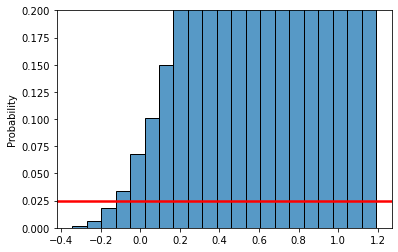

In [20]:
bootstrap('y_hat_0', 'y_0',
          bootstrap_samples=1000,
          RESEARCH_POINTS=500)

Средняя прибыль: 0.44
Риск убытков: 1.6%
95%-й доверительный интервал: [0.02, 0.82]



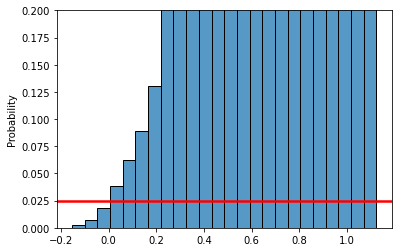

In [21]:
bootstrap('y_hat_1', 'y_1',
          bootstrap_samples=1000,
          RESEARCH_POINTS=500)

Средняя прибыль: 0.42
Риск убытков: 4.9%
95%-й доверительный интервал: [-0.08, 0.88]



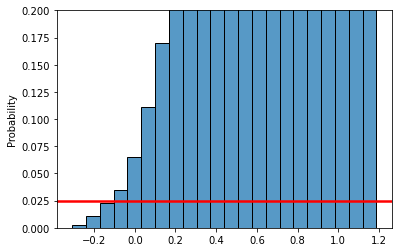

In [22]:
bootstrap('y_hat_2', 'y_2',
          bootstrap_samples=1000,
          RESEARCH_POINTS=500)

# Выводы:

* Определен регион с максимальной суммарной прибылью отобранных скважин.
* Проанализированы возможные прибыль и риски техникой Bootstrap.
* В соответствии с условиями задачи оптимальным для разработки скважин является регионом 1 (geo_data_1). Несмотря на то, что средний запас предсказанного сырья в нем наименьший, только в этом регионе вероятность убытков меньше 2.5% при разведке региона в 500 точек. Это связано с тем, что модель значительно лучше работает на данных из 1 региона. 
* Если увеличить разведку, то вероятность отобрать максимально доходные точки растет. Так, при research_points равной 3500, регион 0 становится прибыльнее 1, а вероятность получить убыток стремится к нулю.